In [1]:
# download the dataset and normalise

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

#load the consolidated dataset
df = pd.read_csv(r'C:\Users\alexm\FX_project\2000_2024\data2.csv')

# remove extra rows and columns
df = df.iloc[200:5383, 0:62]

# reformat Local time variable as a datetime
from datetime import datetime

df['Date'] = df['Date'].str[6:10] +'-'+ df['Date'].str[3:5] +'-'+ df['Date'].str[0:2]
df['Date'] = pd.to_datetime(df['Date'])

# normalise data

df_norm = df.iloc[:, 5:]
df_dates = df.iloc[:, :5]

for col in df_norm.columns:
    df_norm[col] = (df_norm[col] - df_norm[col].mean())/ df_norm[col].std()

x = df_norm.to_numpy()
y = df_dates.to_numpy()
cols = df.columns
z = np.append(y,x, axis=1)

df_norm2 = pd.DataFrame(z, columns=cols)

# add an integer series to replace date for use in the ANN
df_norm2['DateID'] = range(df_norm2.shape[0])
first_column = df_norm2.pop('DateID') 
df_norm2.insert(0, 'DateID', first_column)

df_norm2.iloc[:,2:] = df_norm2.iloc[:,2:].astype(float)

df_norm2.info()

C:\Users\alexm\AppData\Local\Temp\ipykernel_38576\4247761149.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\alexm\FX_project\2000_2024\data2.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5183 entries, 0 to 5182
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DateID           5183 non-null   int64         
 1   Date             5183 non-null   datetime64[ns]
 2   Day              5183 non-null   float64       
 3   Month            5183 non-null   float64       
 4   Year             5183 non-null   float64       
 5   Close_Mid        5183 non-null   float64       
 6   Volume_Bid       5183 non-null   float64       
 7   Volume_Ask       5183 non-null   float64       
 8   Volume_Tot       5183 non-null   float64       
 9   Close_Sprd       5183 non-null   float64       
 10  5D-MA            5183 non-null   float64       
 11  10D-MA           5183 non-null   float64       
 12  20D-MA           5183 non-null   float64       
 13  50D-MA           5183 non-null   float64       
 14  200D-MA          5183 non-null   float64

In [2]:
# hive off the last 250 days data for a prediction

df_test = df_norm2.iloc[df_norm2.shape[0]-250:,:]
df_test.head()

,DateID,Date,Day,Month,Year,Close_Mid,Volume_Bid,Volume_Ask,Volume_Tot,Close_Sprd,...,UK-NomGDP,UK-CPI,UK-Unemp,UK-CorpProf,UK-HshldInc,UK-ResPropInc,UK-SecLend,UK-ConsCred,UK-RetailVol,UK-MktVol
4933,4933,2023-01-15,15.0,1.0,2023.0,1.219420,-0.209503,-0.140696,-0.175159,2.311566,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801
4934,4934,2023-01-16,16.0,1.0,2023.0,1.228860,-0.109409,-0.083422,-0.096491,1.455494,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801
4935,4935,2023-01-17,17.0,1.0,2023.0,1.234605,-0.045891,0.008800,-0.018383,0.935736,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801
4936,4936,2023-01-18,18.0,1.0,2023.0,1.239040,-0.221529,-0.158080,-0.189909,1.333198,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801
4937,4937,2023-01-19,19.0,1.0,2023.0,1.239615,-0.223691,-0.205885,-0.215098,-0.103779,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801


In [3]:
df_train = df_norm2.iloc[:df_norm2.shape[0]-250, :]
df_train.tail()

,DateID,Date,Day,Month,Year,Close_Mid,Volume_Bid,Volume_Ask,Volume_Tot,Close_Sprd,...,UK-NomGDP,UK-CPI,UK-Unemp,UK-CorpProf,UK-HshldInc,UK-ResPropInc,UK-SecLend,UK-ConsCred,UK-RetailVol,UK-MktVol
4928,4928,2023-01-08,8.0,1.0,2023.0,1.218415,0.106910,-0.150495,-0.022747,1.424920,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801
4929,4929,2023-01-09,9.0,1.0,2023.0,1.215080,0.205895,-0.191253,0.005920,1.516642,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801
4930,4930,2023-01-10,10.0,1.0,2023.0,1.214840,-0.115639,-0.193479,-0.155105,1.394346,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801
4931,4931,2023-01-11,11.0,1.0,2023.0,1.221140,0.158115,0.138647,0.148570,1.333198,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801
4932,4932,2023-01-12,12.0,1.0,2023.0,1.222505,-0.055210,-0.042834,-0.049063,-0.042631,...,2.006504,2.226855,-1.187929,1.882021,1.971516,2.325618,-0.089193,1.193368,-1.200179,0.728801


In [4]:
# Create input and output datasets
columns = ['Close_Mid','Volume_Tot','Close_Sprd','US-BaseRate', 'UK-BaseRate','UK-5Y-Inf','US-2Y-Int',
                     'US-10Y-Int','UK-2Y-Int','UK-10Y-Int','US-RealGDP','US-Unemp', 'US-CPI','US-HousePrice',
                     'US-CommmRealEst','US-MktVol','UK-RealGDP','UK-CPI','UK-Unemp','UK-CorpProf',
                     'UK-HshldInc','UK-ResPropInc','UK-SecLend','UK-ConsCred','UK-RetailVol','UK-MktVol']

X_train = df_train[columns]
X_test = df_test[columns]

y_train = df_train[['Close_Mid']] 
y_test = df_test[['Close_Mid']] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (4933, 26) (4933, 1)
Testing Shape (250, 26) (250, 1)


In [5]:
from torch.autograd import Variable

X_train_tensors = Variable(torch.tensor(X_train.iloc[4500:,:].to_numpy(), requires_grad=True, dtype=float))
X_train_tensors = X_train_tensors.to(torch.float32)
X_test_tensors = Variable(torch.tensor(X_test.to_numpy(), requires_grad=True, dtype=float))
X_test_tensors = X_test_tensors.to(torch.float32)

y_train_tensors = Variable(torch.tensor(y_train.iloc[4500:,:].to_numpy(), requires_grad=True, dtype=float))
y_train_tensors = y_train_tensors.to(torch.float32)
y_test_tensors = Variable(torch.tensor(y_test.to_numpy(), requires_grad=True, dtype=float))
y_test_tensors = y_test_tensors.to(torch.float32)

X_train_tensors.shape[0]

433

In [6]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([433, 1, 26]) torch.Size([433, 1])
Testing Shape torch.Size([250, 1, 26]) torch.Size([250, 1])


In [8]:
# create the model
# https://cnvrg.io/pytorch-lstm/

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length): # initialise the class
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes attribute
        self.num_layers = num_layers #number of layers attribute
        self.input_size = input_size #input size attribute
        self.hidden_size = hidden_size #hidden state attribute
        self.seq_length = seq_length #sequence length attribute

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM function definition
        self.fc_1 =  nn.Linear(hidden_size, 100) #fully connected 1 function definition
        self.fc = nn.Linear(100, num_classes) #fully connected last layer function definition
        self.relu = nn.LeakyReLU(negative_slope=0.3) # define activation
    
    def forward(self,x): # specify the forward propogation of the class (note this is overriding the forward function of the
    # nn.Module class as required by the nn.module class this is inheriting from). x is the dataset input.
        
        # instantiate the internal states of the LSTM module with zeros
        h_0 = Variable(torch.ones(self.num_layers, x.size(0), self.hidden_size)) # create the hidden state of the LSTM,
        c_0 = Variable(torch.ones(self.num_layers, x.size(0), self.hidden_size)) # create the internal state of the LSTM
        
        # Propagate input through model
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #LSTM with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for the input to the next dense layer
        out = self.relu(hn) # activation on the LSTM cell
        out = self.fc_1(out) # 1st Dense propogation
        out = self.relu(out) # ReLU on the first dense layer
        out = self.fc(out) # Final Output. Why is there no final activation after this step?
        out = self.relu(out) # ReLU on the final dense layer
        return out
 

In [9]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) # instantiate our lstm class

In [19]:
# Define the parameters of the model
num_epochs = 2000
learning_rate = 0.001

input_size = 26 # Represents the number of features
hidden_size = 100 # Represents the number of features in hidden state
num_layers = 1 # Represents the number of stacked lstm layers

num_classes = 1 # Represents the number of output classes

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) # Optimizer chosen as Adam

In [20]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) # Forward pass on the training data
  optimizer.zero_grad() # Caluclate the gradient,  resetting to 0 for the new pass
 
  loss = criterion(outputs, y_train_tensors) # Compare the output of the model with the actual via MSE loss
 
  loss.backward() # Calculate the MSE loss gradients
 
  optimizer.step() # Backprogate
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) # Print out the MSE after every 100 epochs
print("Final MSE: ", loss.item())



Epoch: 0, loss: 0.00025
Epoch: 100, loss: 0.00023
Epoch: 200, loss: 0.00022
Epoch: 300, loss: 0.00020
Epoch: 400, loss: 0.00015
Epoch: 500, loss: 0.00013
Epoch: 600, loss: 0.00011
Epoch: 700, loss: 0.00014
Epoch: 800, loss: 0.00011
Epoch: 900, loss: 0.00011
Epoch: 1000, loss: 0.00010
Epoch: 1100, loss: 0.00010
Epoch: 1200, loss: 0.00014
Epoch: 1300, loss: 0.00010
Epoch: 1400, loss: 0.00011
Epoch: 1500, loss: 0.00010
Epoch: 1600, loss: 0.00009
Epoch: 1700, loss: 0.00020
Epoch: 1800, loss: 0.00011
Epoch: 1900, loss: 0.00009
Final MSE:  0.00023635884281247854


In [15]:
# create predictions
df_pred = df_norm2[columns]
# convert to tensor
df_pred = Variable(torch.Tensor(df_pred.to_numpy()))
df_pred = torch.reshape(df_pred, (df_pred.shape[0], 1, df_pred.shape[1]))

train_predict = lstm1(df_pred)


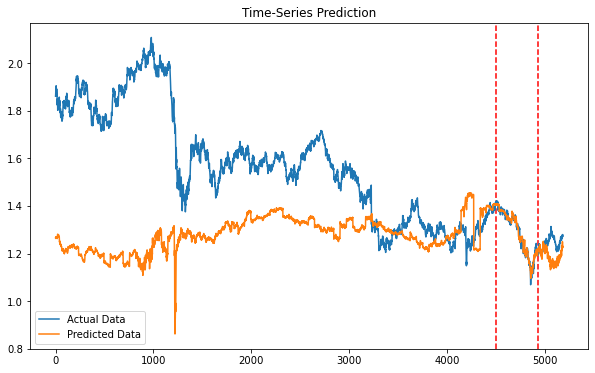

In [18]:
# visualise results

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_predict = train_predict.data.numpy() # Convert predicts to numpy for charting
dataY_plot = df_norm2['Close_Mid'] # Convert actuals to numpy for charting

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4933, c='r', linestyle='--') # Separator for the training and prediction datasets
plt.axvline(x=4500, c='r', linestyle='--')

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 